## Import Libaries

In [1]:
# Numeric Libaries
import numpy as np

# Mediapipe Libaries
import mediapipe as mp

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model

# Scikit Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

# Plot Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Camera Libaries
import cv2

# Other Libraries
import os

## Declare Mediapipe Variables

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

In [3]:
# Draw and Set Landmark
def draw_landmarks(img, res):
    # Render Left Hand Connections
    mp_drawing.draw_landmarks(img, res.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                            ) 
    # Render Right Hand Connections
    mp_drawing.draw_landmarks(img, res.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                            )           

def mediapipe_detection(img, model):
    # Set Flags Writeable False, to optimze the detection process
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False
        
    # Holistic model return landmarks
    results = model.process(img)

    # Draw Detection on the footage/image
    img.flags.writeable = True
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
    return img, results

## Dataset Collection

In [4]:
def generate_keypoints(results):
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
        
    return np.concatenate([left_hand, right_hand])

In [5]:
# Check Label Folder (Create if not exists)
def create_folder_label(dataset_dir, label, sequence_length):
        
    for sequence_num in range(sequence_length):
        try:
            os.makedirs(os.path.join(dataset_dir, label, str(sequence_num)))
        except:
            pass

In [6]:
def collect_dataset(dataset_dir, label_name, sequence_length, frame_length):
    create_folder_label(dataset_dir, label_name, sequence_length)
    cap = cv2.VideoCapture(0)
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4) as holistic:
        # Loop through sequences aka videos
        for sequence in range(0, sequence_length):
            # Loop through video length aka sequence length
            for frame_num in range(frame_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_landmarks(image, results)

                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(label_name, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(100)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(label_name, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                # NEW Export keypoints
                keypoints = generate_keypoints(results)
                npy_path = os.path.join(dataset_dir, label_name, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

## Declare Some Variables

In [7]:
dataset_dir = os.path.join("dataset_collections")
sequence_length = 30
frame_length = 30

## Main

In [8]:
def main():
    label_name = input("Enter Label Name:")
    collect_dataset(dataset_dir, label_name, sequence_length, frame_length)

In [98]:
if __name__ == "__main__":
    main()

Enter Label Name:P


## Processing Data

In [37]:
def fast_scandir(dirname):
    labels = []
    for root, dirs, _ in os.walk(dirname):
        labels = dirs
        break
    return labels

In [38]:
actions = fast_scandir(dataset_dir)

In [39]:
actions = np.array(actions)

In [40]:
label_map = {label:num for num, label in enumerate(actions)}

In [41]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(dataset_dir, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(dataset_dir, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [42]:
X = np.array(sequences)

In [43]:
Y = to_categorical(labels).astype(int)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, shuffle=True)

## Create Model

In [92]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [93]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [94]:
model.fit(X_train, y_train, epochs=1400)

Epoch 1/1400
24/24 [==============================] - 3s 31ms/step - loss: 3.2585 - categorical_accuracy: 0.0364
Epoch 2/1400
24/24 [==============================] - 1s 28ms/step - loss: 3.2506 - categorical_accuracy: 0.0472
Epoch 3/1400
24/24 [==============================] - 1s 29ms/step - loss: 4.4707 - categorical_accuracy: 0.0486
Epoch 4/1400
24/24 [==============================] - 1s 28ms/step - loss: 3.2557 - categorical_accuracy: 0.0310
Epoch 5/1400
24/24 [==============================] - 1s 29ms/step - loss: 3.2080 - categorical_accuracy: 0.0391
Epoch 6/1400
24/24 [==============================] - 1s 28ms/step - loss: 3.1250 - categorical_accuracy: 0.0648
Epoch 7/1400
24/24 [==============================] - 1s 29ms/step - loss: 3.1514 - categorical_accuracy: 0.0702
Epoch 8/1400
24/24 [==============================] - 1s 29ms/step - loss: 3.0453 - categorical_accuracy: 0.0540
Epoch 9/1400
24/24 [==============================] - 1s 29ms/step - loss: 2.9907 - categorical_

24/24 [==============================] - 1s 29ms/step - loss: 0.8694 - categorical_accuracy: 0.6680
Epoch 73/1400
24/24 [==============================] - 1s 29ms/step - loss: 1.0407 - categorical_accuracy: 0.5992
Epoch 74/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.7433 - categorical_accuracy: 0.7301
Epoch 75/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.6603 - categorical_accuracy: 0.7530
Epoch 76/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.7254 - categorical_accuracy: 0.7382
Epoch 77/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.8960 - categorical_accuracy: 0.6707
Epoch 78/1400
24/24 [==============================] - 1s 29ms/step - loss: 1.2126 - categorical_accuracy: 0.5425
Epoch 79/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.8350 - categorical_accuracy: 0.6802
Epoch 80/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.6091 - categorical_accur

24/24 [==============================] - 1s 28ms/step - loss: 0.2072 - categorical_accuracy: 0.9217
Epoch 144/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.1727 - categorical_accuracy: 0.9312
Epoch 145/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.2662 - categorical_accuracy: 0.8961
Epoch 146/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.3334 - categorical_accuracy: 0.8745
Epoch 147/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.3660 - categorical_accuracy: 0.8556
Epoch 148/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.3558 - categorical_accuracy: 0.8596
Epoch 149/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.2595 - categorical_accuracy: 0.9055
Epoch 150/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.3110 - categorical_accuracy: 0.8785
Epoch 151/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.2250 - categoric

24/24 [==============================] - 1s 28ms/step - loss: 0.2995 - categorical_accuracy: 0.9001
Epoch 215/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.1711 - categorical_accuracy: 0.9474
Epoch 216/1400
24/24 [==============================] - 1s 28ms/step - loss: 4.5229 - categorical_accuracy: 0.6370
Epoch 217/1400
24/24 [==============================] - 1s 28ms/step - loss: 1.8116 - categorical_accuracy: 0.4116
Epoch 218/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.9995 - categorical_accuracy: 0.6775
Epoch 219/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.6367 - categorical_accuracy: 0.8043
Epoch 220/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.7086 - categorical_accuracy: 0.8178
Epoch 221/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.5864 - categorical_accuracy: 0.7868
Epoch 222/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.3757 - categoric

24/24 [==============================] - 1s 28ms/step - loss: 0.0956 - categorical_accuracy: 0.9690
Epoch 286/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0866 - categorical_accuracy: 0.9717
Epoch 287/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0591 - categorical_accuracy: 0.9784
Epoch 288/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0635 - categorical_accuracy: 0.9798
Epoch 289/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0490 - categorical_accuracy: 0.9838
Epoch 290/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.1484 - categorical_accuracy: 0.9501
Epoch 291/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.2288 - categorical_accuracy: 0.9001
Epoch 292/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.1085 - categorical_accuracy: 0.9582
Epoch 293/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.1422 - categoric

24/24 [==============================] - 1s 28ms/step - loss: 0.5149 - categorical_accuracy: 0.8273
Epoch 356/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.1258 - categorical_accuracy: 0.9649
Epoch 357/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0641 - categorical_accuracy: 0.9919
Epoch 358/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0386 - categorical_accuracy: 0.9933
Epoch 359/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0305 - categorical_accuracy: 0.9960
Epoch 360/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0249 - categorical_accuracy: 0.9933
Epoch 361/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0465 - categorical_accuracy: 0.9838
Epoch 362/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0813 - categorical_accuracy: 0.9636
Epoch 363/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0574 - categoric

24/24 [==============================] - 1s 28ms/step - loss: 0.1769 - categorical_accuracy: 0.9312
Epoch 427/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.1238 - categorical_accuracy: 0.9487
Epoch 428/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0790 - categorical_accuracy: 0.9771
Epoch 429/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0664 - categorical_accuracy: 0.9757
Epoch 430/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0282 - categorical_accuracy: 0.9946
Epoch 431/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0168 - categorical_accuracy: 0.9960
Epoch 432/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0162 - categorical_accuracy: 0.9960
Epoch 433/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0136 - categorical_accuracy: 0.9973
Epoch 434/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0129 - categoric

24/24 [==============================] - 1s 28ms/step - loss: 0.0338 - categorical_accuracy: 0.9960
Epoch 498/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0257 - categorical_accuracy: 0.9973
Epoch 499/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0361 - categorical_accuracy: 0.9892
Epoch 500/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0220 - categorical_accuracy: 0.9946
Epoch 501/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0147 - categorical_accuracy: 0.9973
Epoch 502/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0152 - categorical_accuracy: 0.9960
Epoch 503/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0108 - categorical_accuracy: 0.9960
Epoch 504/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0099 - categorical_accuracy: 0.9973
Epoch 505/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0097 - categoric

24/24 [==============================] - 1s 28ms/step - loss: 0.0051 - categorical_accuracy: 0.9973
Epoch 568/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0050 - categorical_accuracy: 0.9960
Epoch 569/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0052 - categorical_accuracy: 0.9960
Epoch 570/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0051 - categorical_accuracy: 0.9960
Epoch 571/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0051 - categorical_accuracy: 0.9973
Epoch 572/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0049 - categorical_accuracy: 0.9973
Epoch 573/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0052 - categorical_accuracy: 0.9960
Epoch 574/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0051 - categorical_accuracy: 0.9973
Epoch 575/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0051 - categoric

24/24 [==============================] - 1s 28ms/step - loss: 0.6443 - categorical_accuracy: 0.7733
Epoch 639/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.4940 - categorical_accuracy: 0.8300
Epoch 640/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.4862 - categorical_accuracy: 0.8259
Epoch 641/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.5242 - categorical_accuracy: 0.8070
Epoch 642/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.3479 - categorical_accuracy: 0.8880
Epoch 643/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.2589 - categorical_accuracy: 0.9217
Epoch 644/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.5366 - categorical_accuracy: 0.7989
Epoch 645/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.3228 - categorical_accuracy: 0.9082
Epoch 646/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.3069 - categoric

24/24 [==============================] - 1s 28ms/step - loss: 0.0190 - categorical_accuracy: 0.9946
Epoch 710/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0318 - categorical_accuracy: 0.9865
Epoch 711/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.1433 - categorical_accuracy: 0.9487
Epoch 712/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.2184 - categorical_accuracy: 0.9271
Epoch 713/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.1509 - categorical_accuracy: 0.9393
Epoch 714/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0894 - categorical_accuracy: 0.9622
Epoch 715/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.1020 - categorical_accuracy: 0.9636
Epoch 716/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0883 - categorical_accuracy: 0.9636
Epoch 717/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.1047 - categoric

24/24 [==============================] - 1s 29ms/step - loss: 0.0064 - categorical_accuracy: 0.9960
Epoch 781/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0064 - categorical_accuracy: 0.9960
Epoch 782/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0057 - categorical_accuracy: 0.9973
Epoch 783/1400
24/24 [==============================] - 1s 28ms/step - loss: 1.0597 - categorical_accuracy: 0.7962
Epoch 784/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.7943 - categorical_accuracy: 0.7557
Epoch 785/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.2953 - categorical_accuracy: 0.9123
Epoch 786/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.1682 - categorical_accuracy: 0.9528
Epoch 787/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.1254 - categorical_accuracy: 0.9649
Epoch 788/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0588 - categoric

24/24 [==============================] - 1s 29ms/step - loss: 0.0052 - categorical_accuracy: 0.9960
Epoch 852/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0050 - categorical_accuracy: 0.9973
Epoch 853/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0049 - categorical_accuracy: 0.9973
Epoch 854/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0053 - categorical_accuracy: 0.9973
Epoch 855/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0051 - categorical_accuracy: 0.9973
Epoch 856/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0050 - categorical_accuracy: 0.9973
Epoch 857/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0049 - categorical_accuracy: 0.9973
Epoch 858/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0052 - categorical_accuracy: 0.9960
Epoch 859/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0050 - categoric

24/24 [==============================] - 1s 29ms/step - loss: 0.4141 - categorical_accuracy: 0.8489
Epoch 923/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.2607 - categorical_accuracy: 0.9123
Epoch 924/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.2887 - categorical_accuracy: 0.9177
Epoch 925/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.2946 - categorical_accuracy: 0.8907
Epoch 926/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.4082 - categorical_accuracy: 0.8529
Epoch 927/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.2123 - categorical_accuracy: 0.9150
Epoch 928/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.2056 - categorical_accuracy: 0.9231
Epoch 929/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.1560 - categorical_accuracy: 0.9501
Epoch 930/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.1480 - categoric

24/24 [==============================] - 1s 29ms/step - loss: 0.0725 - categorical_accuracy: 0.9865
Epoch 994/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0601 - categorical_accuracy: 0.9879
Epoch 995/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0524 - categorical_accuracy: 0.9879
Epoch 996/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0502 - categorical_accuracy: 0.9892
Epoch 997/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0401 - categorical_accuracy: 0.9906
Epoch 998/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.1067 - categorical_accuracy: 0.9582
Epoch 999/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0459 - categorical_accuracy: 0.9906
Epoch 1000/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0385 - categorical_accuracy: 0.9892
Epoch 1001/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0278 - categor

24/24 [==============================] - 1s 29ms/step - loss: 0.0808 - categorical_accuracy: 0.9717
Epoch 1064/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0599 - categorical_accuracy: 0.9757
Epoch 1065/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0257 - categorical_accuracy: 0.9919
Epoch 1066/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0220 - categorical_accuracy: 0.9933
Epoch 1067/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0266 - categorical_accuracy: 0.9919
Epoch 1068/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0208 - categorical_accuracy: 0.9946
Epoch 1069/1400
24/24 [==============================] - 1s 30ms/step - loss: 0.0485 - categorical_accuracy: 0.9811
Epoch 1070/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0263 - categorical_accuracy: 0.9906
Epoch 1071/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0179 - c

24/24 [==============================] - 1s 28ms/step - loss: 0.0122 - categorical_accuracy: 0.9960
Epoch 1134/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0088 - categorical_accuracy: 0.9987
Epoch 1135/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0148 - categorical_accuracy: 0.9946
Epoch 1136/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0116 - categorical_accuracy: 0.9987
Epoch 1137/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0060 - categorical_accuracy: 0.9987
Epoch 1138/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0051 - categorical_accuracy: 0.9973
Epoch 1139/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0109 - categorical_accuracy: 0.9960
Epoch 1140/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0065 - categorical_accuracy: 0.9987
Epoch 1141/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0050 - c

24/24 [==============================] - 1s 30ms/step - loss: 0.0077 - categorical_accuracy: 0.9987
Epoch 1204/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0071 - categorical_accuracy: 0.9987
Epoch 1205/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0065 - categorical_accuracy: 0.9987
Epoch 1206/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0069 - categorical_accuracy: 0.9987
Epoch 1207/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0058 - categorical_accuracy: 0.9987
Epoch 1208/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0054 - categorical_accuracy: 0.9973
Epoch 1209/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0051 - categorical_accuracy: 0.9987
Epoch 1210/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0047 - categorical_accuracy: 0.9973
Epoch 1211/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0044 - c

24/24 [==============================] - 1s 30ms/step - loss: 0.0021 - categorical_accuracy: 0.9987
Epoch 1274/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0021 - categorical_accuracy: 0.9987
Epoch 1275/1400
24/24 [==============================] - 1s 30ms/step - loss: 0.0023 - categorical_accuracy: 0.9987
Epoch 1276/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0025 - categorical_accuracy: 0.9987
Epoch 1277/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0032 - categorical_accuracy: 0.9987
Epoch 1278/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0037 - categorical_accuracy: 0.9987
Epoch 1279/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0032 - categorical_accuracy: 0.9987
Epoch 1280/1400
24/24 [==============================] - 1s 28ms/step - loss: 0.0027 - categorical_accuracy: 0.9987
Epoch 1281/1400
24/24 [==============================] - 1s 29ms/step - loss: 0.0024 - c

KeyboardInterrupt: 

In [95]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 32)            20352     
                                                                 
 lstm_19 (LSTM)              (None, 30, 128)           82432     
                                                                 
 lstm_20 (LSTM)              (None, 64)                49408     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 26)                858       
                                                                 
Total params: 159,290
Trainable params: 159,290
Non-tr

In [96]:
model_path = os.path.join("model_collections", "Alphabets97%")
model.save(model_path)
np.save(os.path.join(model_path, "known_labels"), actions)

INFO:tensorflow:Assets written to: model_collections\Alphabets97%\assets


INFO:tensorflow:Assets written to: model_collections\Alphabets97%\assets


In [97]:
yhat = model.predict(X_test)

In [98]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

## Visualize Data Model Evaluation

In [99]:
yhat_labels = []
ytrue_labels = []

In [100]:
for i in range(0,len(yhat)):
    yhat_labels.append(actions[yhat[i]])
    ytrue_labels.append(actions[ytrue[i]])

In [101]:
cm = confusion_matrix(ytrue_labels, yhat_labels, labels=np.unique(ytrue_labels))
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(ytrue_labels))

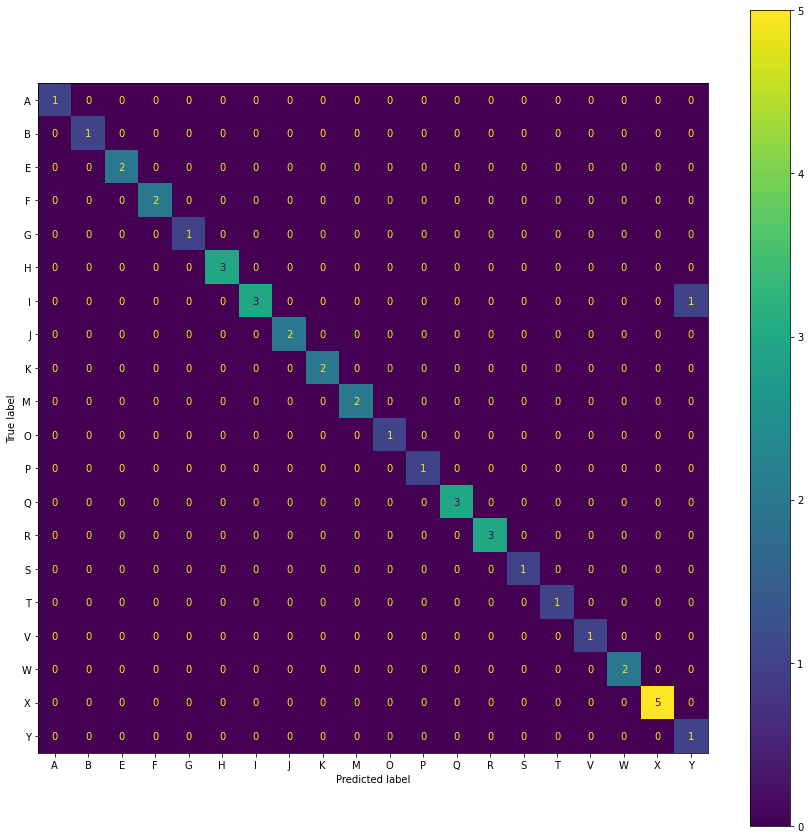

In [102]:
fig, ax = plt.subplots(figsize=(15,15))
cmd.plot(ax=ax)

In [103]:
accuracy_score(ytrue, yhat)

0.9743589743589743

## Realtime Test

In [36]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.98

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = generate_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-20:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs'>
N
<class 'mediapipe.python.solution_base.SolutionOutputs